# Examples:
Let's look at some of the most commonly used things this library can do to collect and post-process IQ data from an RTL-SDR.

In [1]:
import numpy as np
import time

from rtlobs import collect as col
from rtlobs import post_process as post
from rtlobs import utils as ut

%matplotlib widget

### Total power
We can find the total power incident on the SDR by integrating the complex samples at a certain frequency for an amount of time:

In [2]:
# 1024 complex samples per call to the SDR
# 49.6 dB of RtlSdr gain
# 2.4 MHz sample rate/bandwidth
# 1420.6 MHz center frequency
# 10 sec integration time
p_tot = col.run_total_power_int(1024, 49.6, 2.4e6, 1420.4e6, 10)
print('Uncalibrated total power measurement: {}'.format(p_tot))

### Total power calibration 
If p_tot was measured with a telescope pointed at a radio-hot source (e.g. the ground, ~300 Kelvin), and we measure again, this time pointed at a radio-cold source (e.g. empty sky, estimates vary, say ~10 K):

In [3]:
p_hot = p_tot
p_cold = col.run_total_power_int(1024, 49.6, 2.4e6, 1420.4e6, 10)
print('Uncalibrated total power measurement: {}'.format(p_cold))

We can use these power measurements and assumptions of brightness temperature to perform a "Y-factor" calibration of the system temperature, T_sys, as described in [Single-Dish Calibration Techniques at Radio Wavelengths, K. O'Neil, 2002](http://adsabs.harvard.edu/full/2002ASPC..278..293O):

In [4]:
from rtlobs import calibrate as cal
t_sys = cal.y_factor_cal(p_hot, p_cold, 300, 10)

If your assumptions are wrong (for instance, pointing at the ceiling then a window, instead of ground, then sky), T_sys might not come out what you expect.

### Spectral lines
We can estimate the power spectral density recorded by the SDR for a given bandwidth by averaging multiple spectra over time to reduce the noise:

Enabling bias tee.
Found 1 device(s):
  0:  Realtek, RTL2838UHIDIR, SN: 1

Using device 0: Generic RTL2832U OEM
Found Rafael Micro R820T tuner



Found Rafael Micro R820T tuner
[R82XX] PLL not locked!
Exact sample rate is: 2320000.092189 Hz


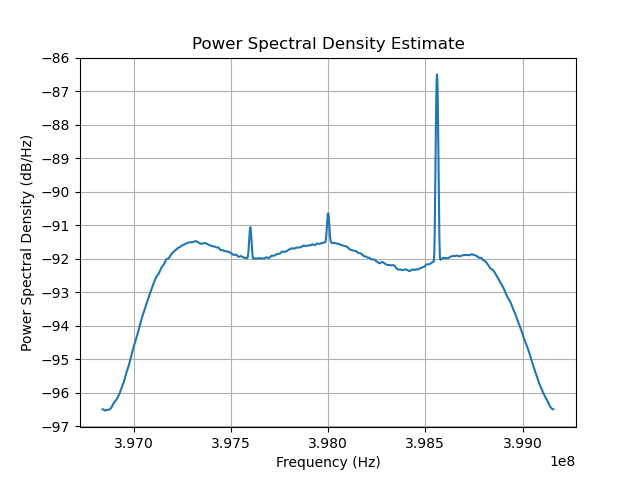

In [5]:
# 8192 samples per call to the SDR
# 2048 bin resolution power spectral density estimate
# 49.6 dB of RtlSdr gain
# 2.32 MHz sample rate/bandwidth
# 1.420 GHz center frequency
# 10 sec integration time
ut.biast(1, index=0) # bias tee
# f, p = col.run_spectrum_int(131072, 2048, 49.6, 2.32e6, 1.420e9, 10)
f, p = col.run_spectrum_int(131072, 2048, 49.6, 2.32e6, 398e6, 10)
# Show the figure containing the plotted spectrum
fig, ax = post.plot_spectrum(f, p, savefig=None)#'../images/spectrum_int.png')

The rtl-sdr library gives us access to GPIO pins on the RTL2832U chip. The RTL-SDRblog v3 dongle breaks them out ot on-board header pins, which we can use to switch a noise source with 3.3V.

Enabling bias tee.
Found 1 device(s):
  0:  Realtek, RTL2838UHIDIR, SN: 1

Using device 0: Generic RTL2832U OEM
Found Rafael Micro R820T tuner



Found Rafael Micro R820T tuner
[R82XX] PLL not locked!
Exact sample rate is: 2320000.092189 Hz


Disabling bias tee.
Found 1 device(s):
  0:  Realtek, RTL2838UHIDIR, SN: 1

Using device 0: Generic RTL2832U OEM
Found Rafael Micro R820T tuner



Found Rafael Micro R820T tuner
[R82XX] PLL not locked!
Exact sample rate is: 2320000.092189 Hz


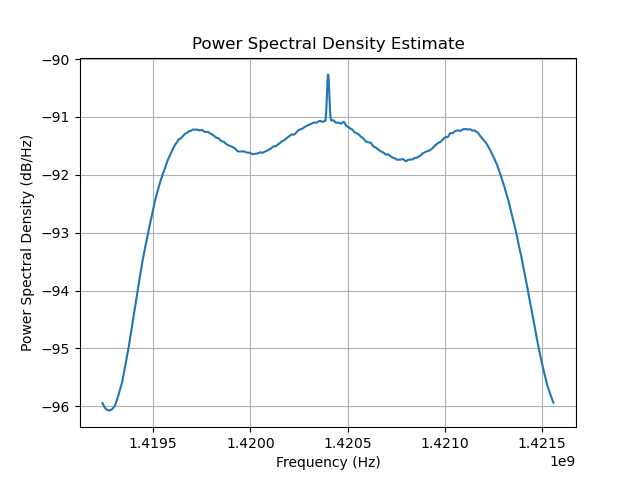

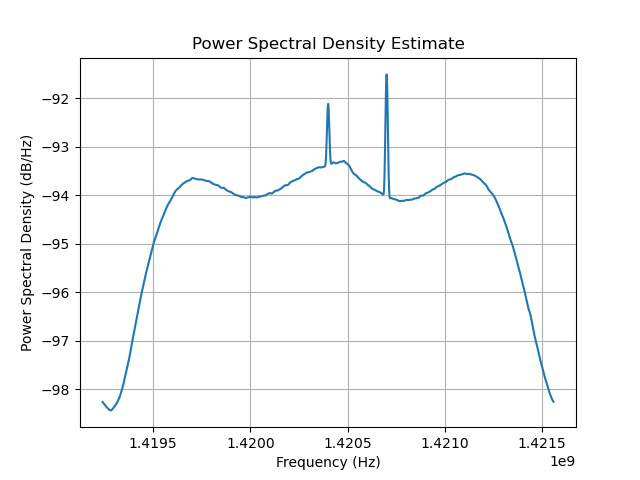

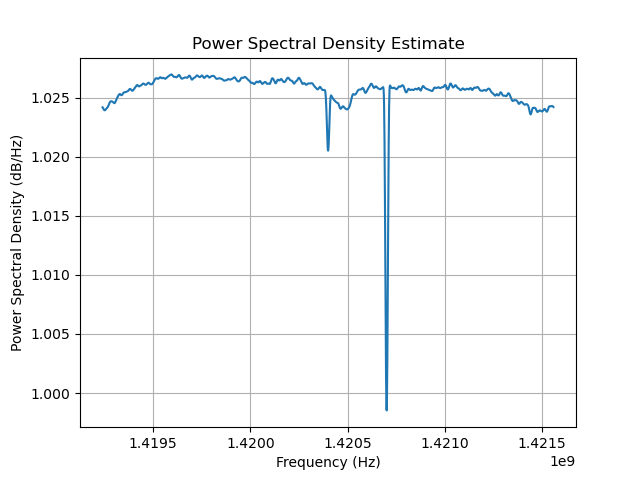

In [7]:
# take a spectrum with the noise source turned on.
# the active gpio on the RTL-SDRblog v3 dongle should be connected to the
# nooelec SAWbird H1+ amp's Vcc pin.
ut.biast(1, index=0, gpio=5) # activate header pin 30
f_off, p_off = col.run_spectrum_int(131072, 2048, 18, 2.32e6, 398e6, 10)
fig, ax = post.plot_spectrum(f_off, p_off) # subtract log quantities by dividing

ut.biast(0, index=0, gpio=5)
f_on, p_on = col.run_spectrum_int(131072, 2048, 18, 2.32e6, 398e6, 10)
fig, ax = post.plot_spectrum(f_on, p_on) # subtract log quantities by dividing

fig, ax = post.plot_spectrum(f_on, p_on / p_off) # subtract log quantities by dividing

And we can even run in frequency-switching mode, periodically retuning the SDR between two frequencies to reduce baseline bandpass shape and increase signal-to-noise on a spectral line!

Note that the folding process performed on frequency-switched data happens in terms of the absolute values (power) rather than relative values (dB), so we make those changes to the plot labels.

In [ ]:
# f, p = col.run_fswitch_int(262144, 2048, 49.6, 2.048e6, 399.75e6, 400.25e6, 30., fswitch=1)
# fig, ax = post.plot_spectrum(f, np.log10(p))
# # Edit figure labels to be technically correct
# ax.set_ylabel('Uncalibrated Power Estimate (V$^2$)')

And we can do this a number of times to collect a time series of spectra.

In [ ]:
ut.biast(1, index=0, gpio=0)

num_pics = 35
for i in range(num_pics):
    time_str = time.strftime('%a, %d %b %Y %H:%M:%S', time.localtime(time.time()))
    print(time_str)
    f, p = col.run_fswitch_int(262144, 2048, 49.6, 2.048e6, 1420.3e6, 1420.7e6, 60., fswitch=1)
    fig, ax = post.plot_spectrum(f, p)
    # ax.set_ylim(-10e-8, 10e-8)
    # Edit figure labels to be technically correct
    ax.set_ylabel('Uncalibrated Power Estimate (V$^2$)')
    ax.set_title(f'Power Spectrum Estimate\n{time_str}')
    fig.savefig(f'../images/fswitch_int_{time_str}.png')
    np.save(f'./output/fswitch_int_freqs_powers_{time_str}.npy', np.array([f, p]))
    fig.show()

ut.biast(0, index=0, gpio=0)

In [7]:
ut.biast(0, index=0, gpio=0)

Disabling bias tee.
Found 1 device(s):
  0:  Realtek, RTL2838UHIDIR, SN: 1

Using device 0: Generic RTL2832U OEM
Found Rafael Micro R820T tuner



In [ ]:
ut.biast(1, index=0, gpio=0)